In [1]:
import os
import sys
notebook_directory = os.getcwd()
sys.path.append(notebook_directory)
import ExpTime_Calc as EC

In [2]:
# Initialize the SED class
model = EC.SED(mag = 20, temperature = 9700)

# Create the spectrum
wavelength,spectrum = model.photon_spectrum()

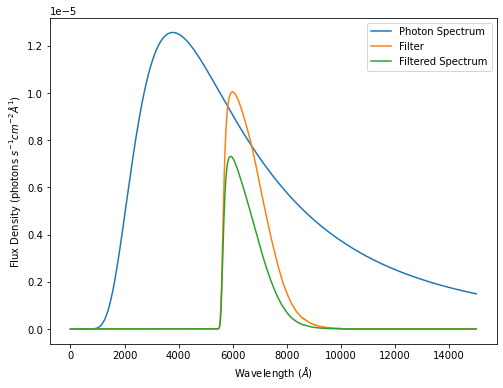

In [3]:
# Initialize the BandPass class
Vband = EC.BandPass('R')

# Filter the spectrum with the filter response
filtered_spectrum = Vband.filter_SED(wavelength, spectrum,plot=True)

In [4]:
model_SED = EC.SED(mag = 10, temperature = 9700)

timstelescope = EC.Telescope(diameter=60,diameter_units='mm',focal_length=600,foc_len_units='mm',mirror=0.8) #create telescope

LasCruces = EC.atmosphere(0.6,seeing=1) #create atmosphere conditions

camera = EC.detector(QE=0.8,px_size=5, read_noise=5) #create detector

In [5]:
observation = EC.Observation(model_SED,                              #initialize observation
                              filter='V',telescope=timstelescope,
                              atmosphere=LasCruces,detector=camera)

1343.77 photons per second
 
7.46 seconds for SNR=100


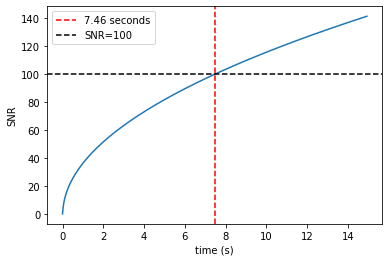

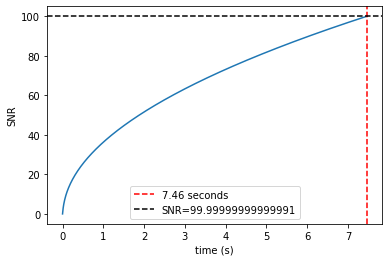

In [6]:
snr = EC.Signal_to_Noise(observation,SNR=100)

time = snr.calc_exptime(plot=True) #calculate time for desired SNR

snr_value = snr.calc_SNR(time,plot=True) #calculate SNR from calculated time


# Spectrograph:

 
22.83 seconds for SNR=50


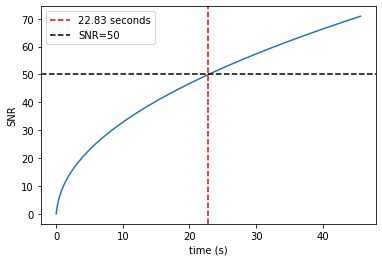

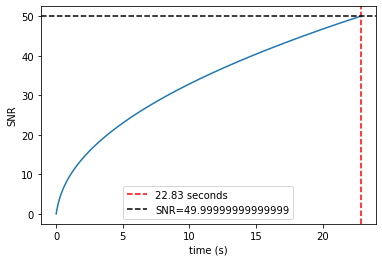

In [9]:
model_SED = EC.SED(mag = 10, temperature = 9700)

timstelescope = EC.Telescope(diameter=60,diameter_units='cm',focal_length=600,foc_len_units='mm',mirror=0.8) #create telescope

LasCruces = EC.atmosphere(0.9,seeing=1) #create atmosphere conditions

camera = EC.detector(QE=0.8,px_size=5, read_noise=5,instrument_type='spectroscopy',dispersion = 1) #create detector

observation = EC.Observation(model_SED,                              #initialize observation
                              filter='V',telescope=timstelescope,
                              atmosphere=LasCruces,detector=camera)

snr = EC.Signal_to_Noise(observation,SNR=50,wavelength=5500)

time = snr.calc_exptime(plot=True) #calculate time for desired SNR

snr_value = snr.calc_SNR(time,plot=True) #calculate SNR from calculated time